In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
tf.__version__

'2.1.0'

In [5]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

In [6]:
DATA_DIR = '../data/car_damage_bundles'

RESULT_DIR = '../results'

MODEL_CONFIG = {
    "model_name": "CarDamageDetectionTF2_Model_1.h5",
    "model_weights": "CarDamageDetectionTF2_Model_1_weights.hdf5",
    "log_dir": "tensorboard_logs",
    "checkpoints_dir": "training1",
    "epochs": 50,
    "batch_size": 64,
    "IMG_HEIGHT": 96,
    "IMG_WIDTH": 96,
    "augmentaion": True,
    "dropouts": True,
    "activation": "softmax",
    "loss": "binary_crossentropy",
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "patience": 5
}

# DATA_FILE_PATH = os.path.join(DATA_DIR, FLAGS.data_file)
MODEL_PATH = os.path.join(RESULT_DIR, "model", MODEL_CONFIG["model_name"])
CHECKPOINTS_PATH = os.path.join(RESULT_DIR, "checkpoints/", MODEL_CONFIG["checkpoints_dir"])
if os.environ.get('JOB_STATE_DIR') is not None:
    LOG_DIR = os.path.join(os.environ["JOB_STATE_DIR"], MODEL_CONFIG["log_dir"])
else:
    LOG_DIR = os.path.join(RESULT_DIR, MODEL_CONFIG["log_dir"])
# ensure_dir(DATA_FILE_PATH)
ensure_dir(MODEL_PATH)
ensure_dir(CHECKPOINTS_PATH)
# global CONFIG
CONFIG = {
            "DATA_DIR": DATA_DIR,
            "RESULT_DIR": RESULT_DIR,
            "MODEL_PATH": MODEL_PATH,
            "LOG_DIR": LOG_DIR,
            "MODEL_CONFIG": MODEL_CONFIG,
            "CHECKPOINTS_PATH": CHECKPOINTS_PATH
         }
print(CONFIG)

# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

{'DATA_DIR': '../data/car_damage_bundles', 'RESULT_DIR': '../results', 'MODEL_PATH': '../results/model/CarDamageDetectionTF2_Model_1.h5', 'LOG_DIR': '../results/tensorboard_logs', 'MODEL_CONFIG': {'model_name': 'CarDamageDetectionTF2_Model_1.h5', 'model_weights': 'CarDamageDetectionTF2_Model_1_weights.hdf5', 'log_dir': 'tensorboard_logs', 'checkpoints_dir': 'training1', 'epochs': 50, 'batch_size': 64, 'IMG_HEIGHT': 96, 'IMG_WIDTH': 96, 'augmentaion': True, 'dropouts': True, 'activation': 'softmax', 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy'], 'patience': 10}, 'CHECKPOINTS_PATH': '../results/checkpoints/training1'}


In [7]:
def get_train_val_generator(data_dir=CONFIG['DATA_DIR'],
                       data_augment=CONFIG['MODEL_CONFIG']['augmentaion'],
                       batch_size=CONFIG['MODEL_CONFIG']['batch_size'],
                       target_size=(CONFIG['MODEL_CONFIG']['IMG_HEIGHT'], CONFIG['MODEL_CONFIG']['IMG_WIDTH']),
                       color_mode='rgb',
                       class_mode='categorical',
                       shuffle=True):
    if data_augment:
        datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2,#this is the trick
                                   horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(CONFIG['MODEL_CONFIG']['IMG_HEIGHT'], CONFIG['MODEL_CONFIG']['IMG_WIDTH']),
        batch_size=CONFIG['MODEL_CONFIG']['batch_size'],
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        subset='training') # set as training data

    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(CONFIG['MODEL_CONFIG']['IMG_HEIGHT'], CONFIG['MODEL_CONFIG']['IMG_WIDTH']),
        batch_size=CONFIG['MODEL_CONFIG']['batch_size'],
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        subset='validation') # set as validation data
    
    
    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = get_train_val_generator(CONFIG['DATA_DIR'], data_augment=True)
# tf.keras.preprocessing.image.DirectoryIterator(
#     PATH, image_data_generator, target_size=(256, 256), color_mode='rgb',
#     classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None,
#     data_format=None, save_to_dir=None, save_prefix='', save_format='png',
#     follow_links=False, subset=None, interpolation='nearest', dtype=None
# )
# training_images, _ = next(train_generator)
total_lables = 0
for image_batch, label_batch in train_generator:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    total_labels = label_batch.shape[1]
    print("Total Labels: ", total_labels)
    break


Found 548 images belonging to 5 classes.
Found 133 images belonging to 5 classes.
Image batch shape:  (64, 96, 96, 3)
Label batch shape:  (64, 5)
Total Labels:  5


In [9]:
def create_model(dropouts=True):
#         total_labels = len(self.data_handler.dataset.validation_dirs)
       
        if dropouts == True:
            print('Apply Dropouts ...')
            model = Sequential([
                Conv2D(16, 3, padding='same', activation='relu', input_shape=(CONFIG['MODEL_CONFIG']['IMG_HEIGHT'], CONFIG['MODEL_CONFIG']['IMG_WIDTH'], 3)),
                MaxPooling2D((2,2), strides=(2,2)),
                Dropout(0.2),
                Conv2D(32, 3, padding='same', activation='relu'),
                MaxPooling2D((2,2), strides=(2,2)),
                Conv2D(64, 3, padding='same', activation='relu'),
                MaxPooling2D((2,2), strides=(2,2)),
                Conv2D(128, 3, padding='same', activation='relu'),
                MaxPooling2D(),
                Dropout(0.2),
                Flatten(),
                Dense(512, activation='relu'),
                Dense(256, activation='relu'),
                Dense(total_labels, activation=CONFIG['MODEL_CONFIG']['activation'])
            ])            
        else:
            print('NO Dropouts ...')
            model = Sequential([
                Conv2D(16, 3, padding='same', activation='relu', input_shape=(self.CONFIG['MODEL_CONFIG']['IMG_HEIGHT'], self.CONFIG['MODEL_CONFIG']['IMG_WIDTH'] ,3)),
                MaxPooling2D(),
                Conv2D(32, 3, padding='same', activation='relu'),
                MaxPooling2D(),
                Conv2D(64, 3, padding='same', activation='relu'),
                MaxPooling2D(),
                Flatten(),
                Dense(512, activation='relu'),
                Dense(total_labels, activation=CONFIG['MODEL_CONFIG']['activation'])
            ])

        base_learning_rate = 0.0001
        # model.compile(optimizer=self.CONFIG['MODEL_CONFIG']['optimizer'],
        #       loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        #       metrics=[self.CONFIG['MODEL_CONFIG']['metrics']])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[CONFIG['MODEL_CONFIG']['metrics']])
        # model.compile(
        #     optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
        #     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        #     metrics=[self.CONFIG['MODEL_CONFIG']['metrics']])
        # model.compile(
        #     optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
        #     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        #     metrics=[self.CONFIG['MODEL_CONFIG']['metrics']])
        model.summary()
        return model

In [10]:
def get_callbacks():
        # Include the epoch in the file name (uses `str.format`)
        checkpoint_path = CONFIG['CHECKPOINTS_PATH']
        checkpoint_dir = os.path.dirname(checkpoint_path+'/cp-{epoch:04d}.ckpt')
        
        logs_dir = CONFIG['MODEL_CONFIG']['RESULT_DIR'] + '/' + CONFIG['MODEL_CONFIG']['log_dir']
        logs_dir = logs_dir + "/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=CONFIG['MODEL_CONFIG']['patience'], monitor='val_loss')

        # Create a callback that saves the model's weights every 5 epochs
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir, 
            monitor='val_acc',
            verbose=1,
            save_best_only=True,
            save_weights_only=True,
            mode='auto',
            save_freq=5)
        return [tensorboard_callback, early_stopping_callback]

In [11]:
def train_model(model, dataset):
        history = model.fit_generator(
            dataset['train'],
            steps_per_epoch = dataset['total_train'] // CONFIG['MODEL_CONFIG']['batch_size'],
            epochs=CONFIG['MODEL_CONFIG']['epochs'],
            validation_data = dataset['validation'],
            validation_steps = dataset['total_val'] // CONFIG['MODEL_CONFIG']['batch_size'],
            callbacks = get_callbacks()
        )
        model.save('../results/model/Car_Damage_Detection.h5')
        print("<<<<<<<< ML MODEL CREATED AND SAVED LOCALLY AT: ", CONFIG["MODEL_PATH"])
        # model.evaluate(val_data_gen)
        return model, history

In [12]:
def check_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(CONFIG['MODEL_CONFIG']['epochs'])

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [13]:
model = create_model()
dataset = {
    'train': train_generator,
    'validation': validation_generator,
    'total_train': 583,
    'total_val': 133
}
model, history = train_model(model, dataset)


Apply Dropouts ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1

9/9 [==============================] - 13s 1s/step - loss: 1.4948 - accuracy: 0.3978 - val_loss: 1.5081 - val_accuracy: 0.3828
Epoch 5/50
9/9 [==============================] - 13s 1s/step - loss: 1.4850 - accuracy: 0.3978 - val_loss: 1.5011 - val_accuracy: 0.3828
Epoch 6/50
9/9 [==============================] - 13s 1s/step - loss: 1.4875 - accuracy: 0.3978 - val_loss: 1.5124 - val_accuracy: 0.3828
Epoch 7/50
9/9 [==============================] - 13s 1s/step - loss: 1.4797 - accuracy: 0.3978 - val_loss: 1.5047 - val_accuracy: 0.3828
Epoch 8/50
9/9 [==============================] - 13s 1s/step - loss: 1.4852 - accuracy: 0.3978 - val_loss: 1.4913 - val_accuracy: 0.3828
Epoch 9/50
9/9 [==============================] - 14s 2s/step - loss: 1.4855 - accuracy: 0.3978 - val_loss: 1.5148 - val_accuracy: 0.3828
Epoch 10/50
2/9 [=====>........................] - ETA: 9s - loss: 1.5354 - accuracy: 0.3359 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


9/9 [==============================] - 13s 1s/step - loss: 1.4785 - accuracy: 0.3978 - val_loss: 1.5031 - val_accuracy: 0.3828
Epoch 11/50
9/9 [==============================] - 13s 1s/step - loss: 1.4719 - accuracy: 0.3978 - val_loss: 1.5098 - val_accuracy: 0.3828
Epoch 12/50
9/9 [==============================] - 13s 1s/step - loss: 1.4699 - accuracy: 0.3978 - val_loss: 1.5092 - val_accuracy: 0.3828
Epoch 13/50
9/9 [==============================] - 13s 1s/step - loss: 1.4684 - accuracy: 0.3996 - val_loss: 1.5148 - val_accuracy: 0.3984
Epoch 14/50
9/9 [==============================] - 13s 1s/step - loss: 1.4621 - accuracy: 0.4015 - val_loss: 1.5164 - val_accuracy: 0.3828
Epoch 15/50
7/9 [======================>.......] - ETA: 2s - loss: 1.4703 - accuracy: 0.4000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


9/9 [==============================] - 13s 1s/step - loss: 1.4594 - accuracy: 0.4051 - val_loss: 1.4935 - val_accuracy: 0.3828
Epoch 16/50
9/9 [==============================] - 14s 2s/step - loss: 1.4656 - accuracy: 0.4051 - val_loss: 1.5360 - val_accuracy: 0.3906
Epoch 17/50
9/9 [==============================] - 13s 1s/step - loss: 1.4505 - accuracy: 0.4124 - val_loss: 1.4775 - val_accuracy: 0.3984
Epoch 18/50
9/9 [==============================] - 13s 1s/step - loss: 1.4436 - accuracy: 0.4106 - val_loss: 1.4884 - val_accuracy: 0.4297
Epoch 19/50
9/9 [==============================] - 13s 1s/step - loss: 1.4280 - accuracy: 0.4051 - val_loss: 1.4969 - val_accuracy: 0.4297
Epoch 20/50
9/9 [==============================] - 13s 1s/step - loss: 1.4097 - accuracy: 0.4270 - val_loss: 1.5364 - val_accuracy: 0.2891
Epoch 21/50
3/9 [=========>....................] - ETA: 7s - loss: 1.4383 - accuracy: 0.4115WARNING:tensorflow:Can save best model only with val_acc available, skipping.


9/9 [==============================] - 13s 1s/step - loss: 1.4001 - accuracy: 0.4234 - val_loss: 1.4933 - val_accuracy: 0.3594
Epoch 22/50
9/9 [==============================] - 13s 1s/step - loss: 1.3860 - accuracy: 0.4380 - val_loss: 1.5287 - val_accuracy: 0.2812
Epoch 23/50
9/9 [==============================] - 13s 1s/step - loss: 1.3861 - accuracy: 0.4471 - val_loss: 1.5141 - val_accuracy: 0.3516
Epoch 24/50
9/9 [==============================] - 13s 1s/step - loss: 1.3757 - accuracy: 0.4398 - val_loss: 1.4740 - val_accuracy: 0.3359
Epoch 25/50
9/9 [==============================] - 13s 1s/step - loss: 1.3487 - accuracy: 0.4416 - val_loss: 1.5087 - val_accuracy: 0.3281
Epoch 26/50
8/9 [=========================>....] - ETA: 1s - loss: 1.3581 - accuracy: 0.4587WARNING:tensorflow:Can save best model only with val_acc available, skipping.


9/9 [==============================] - 13s 1s/step - loss: 1.3674 - accuracy: 0.4507 - val_loss: 1.4688 - val_accuracy: 0.3672
Epoch 27/50
9/9 [==============================] - 13s 1s/step - loss: 1.3451 - accuracy: 0.4690 - val_loss: 1.4743 - val_accuracy: 0.3359
Epoch 28/50
9/9 [==============================] - 13s 1s/step - loss: 1.3410 - accuracy: 0.4580 - val_loss: 1.4461 - val_accuracy: 0.3984
Epoch 29/50
9/9 [==============================] - 14s 2s/step - loss: 1.3335 - accuracy: 0.4617 - val_loss: 1.5311 - val_accuracy: 0.2734
Epoch 30/50
9/9 [==============================] - 14s 2s/step - loss: 1.3031 - accuracy: 0.4653 - val_loss: 1.4969 - val_accuracy: 0.3125
Epoch 31/50
9/9 [==============================] - 14s 2s/step - loss: 1.3197 - accuracy: 0.4653 - val_loss: 1.5279 - val_accuracy: 0.2891
Epoch 32/50
4/9 [============>.................] - ETA: 6s - loss: 1.3456 - accuracy: 0.4605WARNING:tensorflow:Can save best model only with val_acc available, skipping.


9/9 [==============================] - 14s 2s/step - loss: 1.3196 - accuracy: 0.4781 - val_loss: 1.5181 - val_accuracy: 0.2734
Epoch 33/50
9/9 [==============================] - 13s 1s/step - loss: 1.2888 - accuracy: 0.4726 - val_loss: 1.5230 - val_accuracy: 0.2812
Epoch 34/50
9/9 [==============================] - 13s 1s/step - loss: 1.3110 - accuracy: 0.4745 - val_loss: 1.4673 - val_accuracy: 0.3672
Epoch 35/50
9/9 [==============================] - 13s 1s/step - loss: 1.2926 - accuracy: 0.4690 - val_loss: 1.4716 - val_accuracy: 0.3438
Epoch 36/50
9/9 [==============================] - 13s 1s/step - loss: 1.2702 - accuracy: 0.5182 - val_loss: 1.4886 - val_accuracy: 0.3438
Epoch 37/50
9/9 [==============================] - 14s 2s/step - loss: 1.2780 - accuracy: 0.4763 - val_loss: 1.4860 - val_accuracy: 0.3281
Epoch 38/50


9/9 [==============================] - 13s 1s/step - loss: 1.2867 - accuracy: 0.4872 - val_loss: 1.5965 - val_accuracy: 0.2422
<<<<<<<< ML MODEL CREATED AND SAVED LOCALLY AT:  ../results/model/CarDamageDetectionTF2_Model_1.h5


ValueError: x and y must have same first dimension, but have shapes (50,) and (38,)

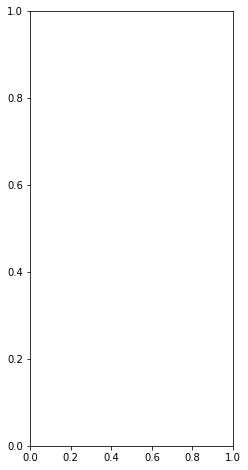

In [14]:
check_accuracy(history)